In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import zipfile
#filtering reshape warnings deprecation
warnings.filterwarnings('ignore')


In [6]:
with zipfile.ZipFile("titanic.zip") as f:
    f.extractall()

In [7]:
#importing data and checking different variables and their types
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data.columns
len(data['Ticket'].unique())

#Dropping id and not useful varibles
data.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
test.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
data.describe(include='all')
data.isnull().sum()
trainy =data['Survived']
data = data.drop(['Survived'],axis=1)
data['Pclass']= pd.Categorical(data['Pclass'])
test['Pclass']= pd.Categorical(test['Pclass'])

In [9]:
data.isnull().sum() 
data[data['Age'].isnull()].index
data['Age']=data['Age'].fillna(data['Age'].mean())
test['Age']=test['Age'].fillna(data['Age'].mean())
trainy.groupby(data['Cabin']).count().head()

Cabin
A10    1
A14    1
A16    1
A19    1
A20    1
Name: Survived, dtype: int64

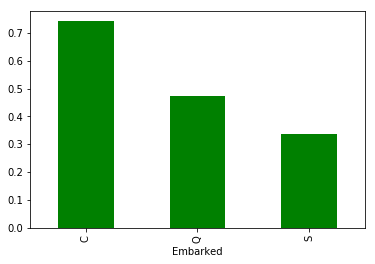

In [10]:
#Extracting character cabin from string
index=pd.Series(data['Cabin'].dropna()).str.slice(0,1).index
data['Cabin'][index]=pd.Series(data['Cabin'].dropna()).str.slice(0,1)

index=pd.Series(test['Cabin'].dropna()).str.slice(0,1).index
test['Cabin'][index]=pd.Series(test['Cabin'].dropna()).str.slice(0,1)

#nan behaves differently, more in number, making it a separate class
trainy.groupby(data['Cabin'].fillna('dummy')).mean()

#Visualization
trainy.groupby(data['Sex']).mean().plot(kind='bar',color='green')
trainy.groupby(data['Pclass']).mean().plot(kind='bar',color='green')
trainy.groupby(data['Embarked']).mean().plot(kind='bar',color='green')


In [11]:
#Removing sparse categories
data['Cabin']=data['Cabin'].replace(['T'],['A'])

In [12]:
#converting to one hot encoding of data
data =pd.get_dummies(data,dummy_na=False,drop_first=True)
test =pd.get_dummies(test,dummy_na=False,drop_first=True)


In [13]:
#splitting data for train test validation
from sklearn.model_selection import train_test_split
trainx, testx, trainy, testy = train_test_split(data, trainy, test_size=0.3, random_state=42)

#Data columns are at different scale, import to normalize before appling gradient descent optim 
def normalize_and_stackintercept(trainx,testx):
    traindatax=trainx
    testdatax=testx
    mu= traindatax.mean(axis=0)
    sigma= traindatax.std(axis=0)
    traindatax= (traindatax-mu)/sigma
    traindatax = np.array(traindatax)    
    traindatax=np.hstack([np.ones((traindatax.shape[0],1)),traindatax])
    testdatax = (testdatax-mu)/sigma
    testdatax = np.array(testdatax)    
    testdatax=np.hstack([np.ones((testdatax.shape[0],1)),testdatax])    
    return traindatax,testdatax

In [14]:
#Data columns are at different scale, import to normalize before appling gradient descent optim
#stacking 1 for intercept term
trainx,testx= normalize_and_stackintercept(trainx,testx)
    
def sigmoid(x):
    prob=1.0/(1+np.exp(-x))
    return prob

In [15]:
#Running loops for gradient descent optimization
    
def Gradient_Descent(trainx,trainy,testx,testy,lr=0.05,reg=0,iters=1000):
    train_m = trainx.shape[0]
    test_m = testx.shape[0]
    trainy=trainy.reshape(train_m,1)
    testy=testy.reshape(test_m,1)
    n = trainx.shape[1]
    coeff= np.zeros((n,1))
    lr=lr
    reg=reg
    train_Loss=[]
    test_Loss=[]

    for iterations in range(iters):
        train_prediction= sigmoid(trainx.dot(coeff))
        test_prediction= sigmoid(testx.dot(coeff))
        train_loss= -np.sum(trainy*np.log(train_prediction)+(1-trainy)*np.log(1-train_prediction))/train_m + 0.5*reg*np.sum(coeff**2)/train_m
        test_loss=  -np.sum(testy*np.log(test_prediction)+(1-testy)*np.log(1-test_prediction))/test_m + 0.5*reg*np.sum(coeff**2)/test_m
        print("iteration "+str(iterations)+"train_loss: "+str(train_loss) +" test_loss: "+str(test_loss))
        train_Loss.append(train_loss)
        test_Loss.append(test_loss) 
        gradient=(trainx.T).dot(train_prediction-trainy)/train_m
        coeff= coeff-lr*(gradient)-(reg*coeff/train_m)
    Loss_dict=pd.DataFrame({'train_Loss':train_Loss,'test_Loss':test_Loss})   
    return coeff,Loss_dict

iteration 0train_loss: 0.6931471805599454 test_loss: 0.6931471805599453
iteration 1train_loss: 0.6856026094181301 test_loss: 0.6855731289907518
iteration 2train_loss: 0.678349532635492 test_loss: 0.6783073760581364
iteration 3train_loss: 0.6713751698895234 test_loss: 0.6713360930395187
iteration 4train_loss: 0.664667203002512 test_loss: 0.6646459470192878
iteration 5train_loss: 0.6582137838135371 test_loss: 0.6582241119226983
iteration 6train_loss: 0.6520035372280184 test_loss: 0.6520582739474637
iteration 7train_loss: 0.6460255601224087 test_loss: 0.6461366321403018
iteration 8train_loss: 0.6402694167469588 test_loss: 0.6404478948368094
iteration 9train_loss: 0.6347251312233464 test_loss: 0.6349812726391036
iteration 10train_loss: 0.6293831776808037 test_loss: 0.6297264685517996
iteration 11train_loss: 0.6242344685178158 test_loss: 0.6246736658373772
iteration 12train_loss: 0.619270341219347 test_loss: 0.6198135140903277
iteration 13train_loss: 0.614482544103986 test_loss: 0.615137113

iteration 383train_loss: 0.4289944017460301 test_loss: 0.45678813589978806
iteration 384train_loss: 0.42897669650453113 test_loss: 0.4567870233934855
iteration 385train_loss: 0.4289591557871405 test_loss: 0.45678597869742893
iteration 386train_loss: 0.4289417778927829 test_loss: 0.45678500079386547
iteration 387train_loss: 0.4289245611401869 test_loss: 0.45678408867944853
iteration 388train_loss: 0.4289075038676236 test_loss: 0.456783241365023
iteration 389train_loss: 0.42889060443264904 test_loss: 0.4567824578754159
iteration 390train_loss: 0.4288738612118503 test_loss: 0.4567817372492289
iteration 391train_loss: 0.42885727260059586 test_loss: 0.4567810785386346
iteration 392train_loss: 0.4288408370127899 test_loss: 0.4567804808091766
iteration 393train_loss: 0.4288245528806288 test_loss: 0.4567799431395724
iteration 394train_loss: 0.4288084186543632 test_loss: 0.45677946462151864
iteration 395train_loss: 0.4287924328020617 test_loss: 0.4567790443595014
iteration 396train_loss: 0.4287

iteration 785train_loss: 0.4270027529015467 test_loss: 0.4576673264598354
iteration 786train_loss: 0.42700205533346475 test_loss: 0.4576695199182253
iteration 787train_loss: 0.42700136268982253 test_loss: 0.457671710120998
iteration 788train_loss: 0.42700067493281557 test_loss: 0.4576738970734893
iteration 789train_loss: 0.4269999920249457 test_loss: 0.4576760807810776
iteration 790train_loss: 0.42699931392901824 test_loss: 0.45767826124918204
iteration 791train_loss: 0.4269986406081388 test_loss: 0.4576804384832626
iteration 792train_loss: 0.42699797202571155 test_loss: 0.45768261248881836
iteration 793train_loss: 0.4269973081454361 test_loss: 0.4576847832713875
iteration 794train_loss: 0.42699664893130523 test_loss: 0.4576869508365456
iteration 795train_loss: 0.42699599434760227 test_loss: 0.45768911518990524
iteration 796train_loss: 0.42699534435889874 test_loss: 0.4576912763371156
iteration 797train_loss: 0.42699469893005176 test_loss: 0.4576934342838606
iteration 798train_loss: 0.

iteration 1202train_loss: 0.42690260404477676 test_loss: 0.458371666382396
iteration 1203train_loss: 0.4269025433209468 test_loss: 0.45837299749149063
iteration 1204train_loss: 0.4269024828555081 test_loss: 0.45837432741821377
iteration 1205train_loss: 0.42690242264683387 test_loss: 0.45837565616510567
iteration 1206train_loss: 0.4269023626933088 test_loss: 0.45837698373469765
iteration 1207train_loss: 0.4269023029933293 test_loss: 0.4583783101295114
iteration 1208train_loss: 0.42690224354530304 test_loss: 0.4583796353520595
iteration 1209train_loss: 0.4269021843476488 test_loss: 0.45838095940484497
iteration 1210train_loss: 0.42690212539879646 test_loss: 0.4583822822903619
iteration 1211train_loss: 0.42690206669718694 test_loss: 0.45838360401109485
iteration 1212train_loss: 0.42690200824127245 test_loss: 0.4583849245695196
iteration 1213train_loss: 0.4269019500295159 test_loss: 0.4583862439681024
iteration 1214train_loss: 0.42690189206039086 test_loss: 0.45838756220930077
iteration 12

iteration 1650train_loss: 0.4268882566135569 test_loss: 0.45887602927303955
iteration 1651train_loss: 0.42688823848774216 test_loss: 0.45887698997015525
iteration 1652train_loss: 0.42688822039210184 test_loss: 0.45887795005856374
iteration 1653train_loss: 0.4268882023265438 test_loss: 0.45887890953885324
iteration 1654train_loss: 0.4268881842909764 test_loss: 0.4588798684116113
iteration 1655train_loss: 0.4268881662853085 test_loss: 0.4588808266774235
iteration 1656train_loss: 0.4268881483094495 test_loss: 0.458881784336874
iteration 1657train_loss: 0.42688813036330925 test_loss: 0.4588827413905456
iteration 1658train_loss: 0.42688811244679814 test_loss: 0.45888369783901956
iteration 1659train_loss: 0.42688809455982685 test_loss: 0.4588846536828758
iteration 1660train_loss: 0.4268880767023068 test_loss: 0.45888560892269264
iteration 1661train_loss: 0.4268880588741496 test_loss: 0.4588865635590473
iteration 1662train_loss: 0.4268880410752676 test_loss: 0.45888751759251517
iteration 1663

iteration 2071train_loss: 0.42688255967559463 test_loss: 0.45923253072953313
iteration 2072train_loss: 0.42688254960611677 test_loss: 0.4592332746591048
iteration 2073train_loss: 0.42688253954933436 test_loss: 0.45923401814756576
iteration 2074train_loss: 0.4268825295052289 test_loss: 0.45923476119520007
iteration 2075train_loss: 0.42688251947378153 test_loss: 0.45923550380229095
iteration 2076train_loss: 0.42688250945497386 test_loss: 0.45923624596912155
iteration 2077train_loss: 0.42688249944878703 test_loss: 0.4592369876959747
iteration 2078train_loss: 0.4268824894552029 test_loss: 0.4592377289831326
iteration 2079train_loss: 0.42688247947420294 test_loss: 0.4592384698308775
iteration 2080train_loss: 0.4268824695057687 test_loss: 0.4592392102394913
iteration 2081train_loss: 0.42688245954988185 test_loss: 0.4592399502092554
iteration 2082train_loss: 0.4268824496065241 test_loss: 0.4592406897404511
iteration 2083train_loss: 0.4268824396756771 test_loss: 0.4592414288333591
iteration 20

iteration 2508train_loss: 0.4268791593094934 test_loss: 0.4595191419672151
iteration 2509train_loss: 0.42687915342758825 test_loss: 0.45951971679856246
iteration 2510train_loss: 0.4268791475528211 test_loss: 0.4595202912912725
iteration 2511train_loss: 0.4268791416851831 test_loss: 0.45952086544554294
iteration 2512train_loss: 0.4268791358246655 test_loss: 0.4595214392615722
iteration 2513train_loss: 0.42687912997125926 test_loss: 0.45952201273955784
iteration 2514train_loss: 0.4268791241249558 test_loss: 0.4595225858796975
iteration 2515train_loss: 0.4268791182857464 test_loss: 0.459523158682189
iteration 2516train_loss: 0.4268791124536217 test_loss: 0.4595237311472298
iteration 2517train_loss: 0.42687910662857337 test_loss: 0.45952430327501703
iteration 2518train_loss: 0.4268791008105926 test_loss: 0.459524875065748
iteration 2519train_loss: 0.42687909499967047 test_loss: 0.4595254465196199
iteration 2520train_loss: 0.4268790891957983 test_loss: 0.45952601763682954
iteration 2521trai

iteration 2929train_loss: 0.4268772182148434 test_loss: 0.45973350260767953
iteration 2930train_loss: 0.42687721468017487 test_loss: 0.4597339509748235
iteration 2931train_loss: 0.4268772111497687 test_loss: 0.4597343990769405
iteration 2932train_loss: 0.4268772076236194 test_loss: 0.45973484691418487
iteration 2933train_loss: 0.426877204101722 test_loss: 0.45973529448671047
iteration 2934train_loss: 0.42687720058407114 test_loss: 0.4597357417946716
iteration 2935train_loss: 0.4268771970706619 test_loss: 0.459736188838222
iteration 2936train_loss: 0.4268771935614889 test_loss: 0.4597366356175157
iteration 2937train_loss: 0.42687719005654706 test_loss: 0.4597370821327065
iteration 2938train_loss: 0.4268771865558314 test_loss: 0.45973752838394805
iteration 2939train_loss: 0.4268771830593367 test_loss: 0.4597379743713938
iteration 2940train_loss: 0.4268771795670577 test_loss: 0.4597384200951975
iteration 2941train_loss: 0.4268771760789894 test_loss: 0.4597388655555123
iteration 2942train_

iteration 3246train_loss: 0.4268762864221607 test_loss: 0.4598631370417781
iteration 3247train_loss: 0.4268762840098666 test_loss: 0.45986350867969383
iteration 3248train_loss: 0.4268762816004752 test_loss: 0.459863880097344
iteration 3249train_loss: 0.426876279193983 test_loss: 0.4598642512948573
iteration 3250train_loss: 0.42687627679038637 test_loss: 0.45986462227236274
iteration 3251train_loss: 0.42687627438968184 test_loss: 0.45986499302998896
iteration 3252train_loss: 0.42687627199186595 test_loss: 0.4598653635678646
iteration 3253train_loss: 0.42687626959693525 test_loss: 0.45986573388611823
iteration 3254train_loss: 0.4268762672048862 test_loss: 0.45986610398487854
iteration 3255train_loss: 0.4268762648157152 test_loss: 0.45986647386427365
iteration 3256train_loss: 0.426876262429419 test_loss: 0.45986684352443236
iteration 3257train_loss: 0.426876260045994 test_loss: 0.45986721296548255
iteration 3258train_loss: 0.4268762576654367 test_loss: 0.45986758218755264
iteration 3259tr

iteration 3645train_loss: 0.42687552157161746 test_loss: 0.45999521264058385
iteration 3646train_loss: 0.42687552007883317 test_loss: 0.4599955058978866
iteration 3647train_loss: 0.4268755185878418 test_loss: 0.4599957989809417
iteration 3648train_loss: 0.4268755170986412 test_loss: 0.4599960918898518
iteration 3649train_loss: 0.42687551561122933 test_loss: 0.4599963846247195
iteration 3650train_loss: 0.4268755141256039 test_loss: 0.4599966771856473
iteration 3651train_loss: 0.426875512641763 test_loss: 0.4599969695727377
iteration 3652train_loss: 0.4268755111597041 test_loss: 0.4599972617860931
iteration 3653train_loss: 0.4268755096794252 test_loss: 0.4599975538258158
iteration 3654train_loss: 0.42687550820092446 test_loss: 0.45999784569200824
iteration 3655train_loss: 0.42687550672419927 test_loss: 0.4599981373847725
iteration 3656train_loss: 0.4268755052492479 test_loss: 0.45999842890421094
iteration 3657train_loss: 0.4268755037760678 test_loss: 0.4599987202504255
iteration 3658trai

iteration 4079train_loss: 0.4268750163885565 test_loss: 0.4601074205761626
iteration 4080train_loss: 0.42687501550212625 test_loss: 0.4601076471014253
iteration 4081train_loss: 0.42687501461675936 test_loss: 0.4601078734918563
iteration 4082train_loss: 0.4268750137324543 test_loss: 0.4601080997475351
iteration 4083train_loss: 0.42687501284920987 test_loss: 0.46010832586854167
iteration 4084train_loss: 0.4268750119670247 test_loss: 0.4601085518549559
iteration 4085train_loss: 0.42687501108589765 test_loss: 0.4601087777068574
iteration 4086train_loss: 0.4268750102058273 test_loss: 0.46010900342432565
iteration 4087train_loss: 0.42687500932681255 test_loss: 0.4601092290074404
iteration 4088train_loss: 0.42687500844885207 test_loss: 0.4601094544562812
iteration 4089train_loss: 0.4268750075719444 test_loss: 0.46010967977092754
iteration 4090train_loss: 0.4268750066960885 test_loss: 0.460109904951459
iteration 4091train_loss: 0.4268750058212832 test_loss: 0.46011012999795464
iteration 4092tr

iteration 4544train_loss: 0.4268747002742427 test_loss: 0.4601994533051267
iteration 4545train_loss: 0.42687469976674336 test_loss: 0.46019962501893175
iteration 4546train_loss: 0.42687469925985194 test_loss: 0.4601997966304149
iteration 4547train_loss: 0.426874698753568 test_loss: 0.46019996813963693
iteration 4548train_loss: 0.42687469824789026 test_loss: 0.4602001395466588
iteration 4549train_loss: 0.4268746977428186 test_loss: 0.4602003108515409
iteration 4550train_loss: 0.4268746972383518 test_loss: 0.4602004820543441
iteration 4551train_loss: 0.42687469673448947 test_loss: 0.4602006531551291
iteration 4552train_loss: 0.4268746962312307 test_loss: 0.46020082415395636
iteration 4553train_loss: 0.42687469572857484 test_loss: 0.4602009950508865
iteration 4554train_loss: 0.42687469522652116 test_loss: 0.4602011658459801
iteration 4555train_loss: 0.42687469472506884 test_loss: 0.46020133653929757
iteration 4556train_loss: 0.42687469422421737 test_loss: 0.4602015071308994
iteration 4557

iteration 4986train_loss: 0.42687452602783477 test_loss: 0.4602661938513458
iteration 4987train_loss: 0.4268745257289998 test_loss: 0.4602663257821382
iteration 4988train_loss: 0.4268745254305225 test_loss: 0.4602664576342642
iteration 4989train_loss: 0.4268745251324025 test_loss: 0.4602665894077705
iteration 4990train_loss: 0.4268745248346392 test_loss: 0.4602667211027039
iteration 4991train_loss: 0.42687452453723257 test_loss: 0.4602668527191112
iteration 4992train_loss: 0.4268745242401818 test_loss: 0.46026698425703916
iteration 4993train_loss: 0.42687452394348663 test_loss: 0.4602671157165345
iteration 4994train_loss: 0.42687452364714645 test_loss: 0.4602672470976437
iteration 4995train_loss: 0.4268745233511612 test_loss: 0.46026737840041376
iteration 4996train_loss: 0.4268745230555302 test_loss: 0.460267509624891
iteration 4997train_loss: 0.426874522760253 test_loss: 0.4602676407711222
iteration 4998train_loss: 0.42687452246532925 test_loss: 0.46026777183915374
iteration 4999train

iteration 5426train_loss: 0.4268744237588468 test_loss: 0.46031726532691014
iteration 5427train_loss: 0.4268744235823921 test_loss: 0.46031736679891233
iteration 5428train_loss: 0.4268744234061485 test_loss: 0.460317468210385
iteration 5429train_loss: 0.42687442323011565 test_loss: 0.4603175695613643
iteration 5430train_loss: 0.4268744230542934 test_loss: 0.46031767085188635
iteration 5431train_loss: 0.42687442287868155 test_loss: 0.46031777208198715
iteration 5432train_loss: 0.42687442270327963 test_loss: 0.4603178732517025
iteration 5433train_loss: 0.42687442252808755 test_loss: 0.46031797436106864
iteration 5434train_loss: 0.42687442235310524 test_loss: 0.46031807541012126
iteration 5435train_loss: 0.4268744221783321 test_loss: 0.46031817639889666
iteration 5436train_loss: 0.4268744220037681 test_loss: 0.4603182773274305
iteration 5437train_loss: 0.42687442182941276 test_loss: 0.4603183781957586
iteration 5438train_loss: 0.4268744216552662 test_loss: 0.460318479003917
iteration 5439

iteration 5862train_loss: 0.42687436378129245 test_loss: 0.4603562315885764
iteration 5863train_loss: 0.4268743636765701 test_loss: 0.46035630981353326
iteration 5864train_loss: 0.4268743635719729 test_loss: 0.4603563879918154
iteration 5865train_loss: 0.4268743634675008 test_loss: 0.46035646612345077
iteration 5866train_loss: 0.42687436336315354 test_loss: 0.4603565442084672
iteration 5867train_loss: 0.4268743632589311 test_loss: 0.4603566222468925
iteration 5868train_loss: 0.4268743631548333 test_loss: 0.46035670023875436
iteration 5869train_loss: 0.4268743630508598 test_loss: 0.4603567781840805
iteration 5870train_loss: 0.4268743629470108 test_loss: 0.4603568560828988
iteration 5871train_loss: 0.42687436284328606 test_loss: 0.4603569339352369
iteration 5872train_loss: 0.42687436273968515 test_loss: 0.4603570117411226
iteration 5873train_loss: 0.42687436263620815 test_loss: 0.4603570895005834
iteration 5874train_loss: 0.42687436253285477 test_loss: 0.46035716721364717
iteration 5875t

iteration 6323train_loss: 0.4268743266500486 test_loss: 0.46038776664032305
iteration 6324train_loss: 0.4268743265897154 test_loss: 0.4603878260474048
iteration 6325train_loss: 0.42687432652945423 test_loss: 0.4603878854190333
iteration 6326train_loss: 0.42687432646926526 test_loss: 0.4603879447552298
iteration 6327train_loss: 0.42687432640914813 test_loss: 0.4603880040560154
iteration 6328train_loss: 0.4268743263491029 test_loss: 0.4603880633214111
iteration 6329train_loss: 0.4268743262891294 test_loss: 0.46038812255143824
iteration 6330train_loss: 0.42687432622922755 test_loss: 0.4603881817461177
iteration 6331train_loss: 0.42687432616939736 test_loss: 0.46038824090547054
iteration 6332train_loss: 0.4268743261096387 test_loss: 0.4603883000295181
iteration 6333train_loss: 0.42687432604995135 test_loss: 0.46038835911828124
iteration 6334train_loss: 0.42687432599033537 test_loss: 0.46038841817178094
iteration 6335train_loss: 0.4268743259307908 test_loss: 0.46038847719003845
iteration 63

iteration 6751train_loss: 0.42687430642682644 test_loss: 0.46041021108628793
iteration 6752train_loss: 0.4268743063906613 test_loss: 0.46041025709805694
iteration 6753train_loss: 0.4268743063545395 test_loss: 0.4604103030823635
iteration 6754train_loss: 0.4268743063184608 test_loss: 0.460410349039224
iteration 6755train_loss: 0.42687430628242534 test_loss: 0.4604103949686549
iteration 6756train_loss: 0.4268743062464328 test_loss: 0.4604104408706724
iteration 6757train_loss: 0.4268743062104833 test_loss: 0.46041048674529306
iteration 6758train_loss: 0.4268743061745769 test_loss: 0.46041053259253295
iteration 6759train_loss: 0.42687430613871324 test_loss: 0.46041057841240873
iteration 6760train_loss: 0.4268743061028925 test_loss: 0.46041062420493656
iteration 6761train_loss: 0.4268743060671145 test_loss: 0.46041066997013264
iteration 6762train_loss: 0.42687430603137927 test_loss: 0.46041071570801345
iteration 6763train_loss: 0.4268743059956868 test_loss: 0.46041076141859527
iteration 676

iteration 7203train_loss: 0.42687429379061526 test_loss: 0.46042844386680193
iteration 7204train_loss: 0.4268742937695477 test_loss: 0.46042847899571243
iteration 7205train_loss: 0.4268742937485052 test_loss: 0.46042851410365404
iteration 7206train_loss: 0.42687429372748786 test_loss: 0.4604285491906393
iteration 7207train_loss: 0.42687429370649566 test_loss: 0.46042858425668076
iteration 7208train_loss: 0.4268742936855285 test_loss: 0.4604286193017909
iteration 7209train_loss: 0.4268742936645864 test_loss: 0.4604286543259821
iteration 7210train_loss: 0.4268742936436693 test_loss: 0.4604286893292671
iteration 7211train_loss: 0.4268742936227772 test_loss: 0.46042872431165816
iteration 7212train_loss: 0.4268742936019101 test_loss: 0.4604287592731679
iteration 7213train_loss: 0.4268742935810679 test_loss: 0.4604287942138085
iteration 7214train_loss: 0.42687429356025053 test_loss: 0.4604288291335927
iteration 7215train_loss: 0.42687429353945816 test_loss: 0.4604288640325329
iteration 7216t

iteration 7620train_loss: 0.4268742868680892 test_loss: 0.4604414151764783
iteration 7621train_loss: 0.4268742868552908 test_loss: 0.46044144256242897
iteration 7622train_loss: 0.42687428684250767 test_loss: 0.4604414699320316
iteration 7623train_loss: 0.4268742868297398 test_loss: 0.460441497285296
iteration 7624train_loss: 0.42687428681698725 test_loss: 0.46044152462223203
iteration 7625train_loss: 0.4268742868042499 test_loss: 0.46044155194284925
iteration 7626train_loss: 0.4268742867915278 test_loss: 0.4604415792471575
iteration 7627train_loss: 0.4268742867788208 test_loss: 0.4604416065351664
iteration 7628train_loss: 0.426874286766129 test_loss: 0.46044163380688585
iteration 7629train_loss: 0.4268742867534524 test_loss: 0.4604416610623255
iteration 7630train_loss: 0.426874286740791 test_loss: 0.46044168830149507
iteration 7631train_loss: 0.42687428672814454 test_loss: 0.4604417155244042
iteration 7632train_loss: 0.42687428671551325 test_loss: 0.4604417427310627
iteration 7633train

iteration 7969train_loss: 0.42687428321371435 test_loss: 0.46045004526142
iteration 7970train_loss: 0.4268742832052806 test_loss: 0.460450067495558
iteration 7971train_loss: 0.42687428319685694 test_loss: 0.4604500897164228
iteration 7972train_loss: 0.42687428318844356 test_loss: 0.46045011192402246
iteration 7973train_loss: 0.42687428318003984 test_loss: 0.46045013411836483
iteration 7974train_loss: 0.42687428317164655 test_loss: 0.4604501562994578
iteration 7975train_loss: 0.42687428316326304 test_loss: 0.46045017846730923
iteration 7976train_loss: 0.4268742831548897 test_loss: 0.4604502006219272
iteration 7977train_loss: 0.42687428314652615 test_loss: 0.4604502227633193
iteration 7978train_loss: 0.4268742831381728 test_loss: 0.46045024489149383
iteration 7979train_loss: 0.42687428312982933 test_loss: 0.46045026700645836
iteration 7980train_loss: 0.4268742831214958 test_loss: 0.46045028910822083
iteration 7981train_loss: 0.42687428311317227 test_loss: 0.4604503111967892
iteration 798

iteration 8356train_loss: 0.42687428059897475 test_loss: 0.4604577302687
iteration 8357train_loss: 0.4268742805936637 test_loss: 0.46045774791503075
iteration 8358train_loss: 0.42687428058835913 test_loss: 0.4604577655508268
iteration 8359train_loss: 0.42687428058306087 test_loss: 0.4604577831760943
iteration 8360train_loss: 0.4268742805777688 test_loss: 0.46045780079083964
iteration 8361train_loss: 0.42687428057248317 test_loss: 0.4604578183950691
iteration 8362train_loss: 0.42687428056720383 test_loss: 0.46045783598878914
iteration 8363train_loss: 0.4268742805619309 test_loss: 0.4604578535720058
iteration 8364train_loss: 0.426874280556664 test_loss: 0.46045787114472536
iteration 8365train_loss: 0.42687428055140353 test_loss: 0.46045788870695414
iteration 8366train_loss: 0.4268742805461494 test_loss: 0.4604579062586985
iteration 8367train_loss: 0.42687428054090154 test_loss: 0.46045792379996453
iteration 8368train_loss: 0.42687428053565984 test_loss: 0.4604579413307586
iteration 8369t

iteration 8777train_loss: 0.4268742788408421 test_loss: 0.4604643010368988
iteration 8778train_loss: 0.42687427883763057 test_loss: 0.4604643147604801
iteration 8779train_loss: 0.4268742788344229 test_loss: 0.4604643284758683
iteration 8780train_loss: 0.42687427883121903 test_loss: 0.4604643421830685
iteration 8781train_loss: 0.42687427882801904 test_loss: 0.4604643558820852
iteration 8782train_loss: 0.4268742788248228 test_loss: 0.4604643695729234
iteration 8783train_loss: 0.4268742788216305 test_loss: 0.46046438325558814
iteration 8784train_loss: 0.426874278818442 test_loss: 0.4604643969300843
iteration 8785train_loss: 0.4268742788152572 test_loss: 0.4604644105964167
iteration 8786train_loss: 0.42687427881207624 test_loss: 0.46046442425458994
iteration 8787train_loss: 0.426874278808899 test_loss: 0.4604644379046092
iteration 8788train_loss: 0.42687427880572565 test_loss: 0.46046445154647936
iteration 8789train_loss: 0.4268742788025562 test_loss: 0.46046446518020523
iteration 8790trai

iteration 9245train_loss: 0.42687427768888564 test_loss: 0.46046990591276565
iteration 9246train_loss: 0.4268742776870496 test_loss: 0.4604699162901486
iteration 9247train_loss: 0.42687427768521574 test_loss: 0.46046992666133607
iteration 9248train_loss: 0.42687427768338415 test_loss: 0.46046993702633154
iteration 9249train_loss: 0.4268742776815548 test_loss: 0.4604699473851391
iteration 9250train_loss: 0.4268742776797276 test_loss: 0.4604699577377621
iteration 9251train_loss: 0.4268742776779026 test_loss: 0.4604699680842043
iteration 9252train_loss: 0.42687427767607966 test_loss: 0.46046997842446946
iteration 9253train_loss: 0.42687427767425895 test_loss: 0.4604699887585614
iteration 9254train_loss: 0.4268742776724404 test_loss: 0.4604699990864835
iteration 9255train_loss: 0.4268742776706241 test_loss: 0.4604700094082396
iteration 9256train_loss: 0.4268742776688099 test_loss: 0.46047001972383345
iteration 9257train_loss: 0.42687427766699787 test_loss: 0.4604700300332686
iteration 9258

iteration 9659train_loss: 0.4268742770888965 test_loss: 0.4604737133734149
iteration 9660train_loss: 0.426874277087777 test_loss: 0.46047372147763965
iteration 9661train_loss: 0.42687427708665876 test_loss: 0.46047372957702587
iteration 9662train_loss: 0.42687427708554176 test_loss: 0.4604737376715765
iteration 9663train_loss: 0.42687427708442616 test_loss: 0.4604737457612944
iteration 9664train_loss: 0.42687427708331194 test_loss: 0.46047375384618244
iteration 9665train_loss: 0.42687427708219894 test_loss: 0.4604737619262437
iteration 9666train_loss: 0.4268742770810874 test_loss: 0.4604737700014808
iteration 9667train_loss: 0.42687427707997705 test_loss: 0.46047377807189666
iteration 9668train_loss: 0.4268742770788682 test_loss: 0.46047378613749435
iteration 9669train_loss: 0.4268742770777605 test_loss: 0.4604737941982765
iteration 9670train_loss: 0.4268742770766542 test_loss: 0.4604738022542462
iteration 9671train_loss: 0.42687427707554926 test_loss: 0.4604738103054061
iteration 9672

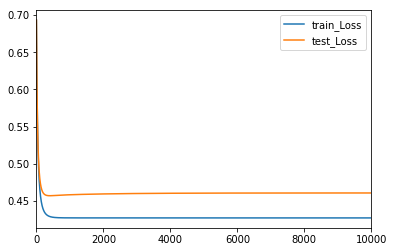

In [17]:
coeff,loss_dict = Gradient_Descent(trainx,trainy.values,testx,testy.values,lr=0.05,reg=0,iters=10000)
loss_dict.plot()


#setting cutoff for class prediction from probability values
cutoff=np.mean(trainy)


In [18]:
def predict_proba(data,coeff):
    return sigmoid(data.dot(coeff))

def predict(data,coeff,cutoff):
    return (sigmoid(data.dot(coeff))>cutoff)*1.0
    

In [19]:
train_prediction= predict(trainx,coeff,cutoff)
test_prediction=  predict(testx,coeff,cutoff)

def accuracy(datay,prediction):
    m= datay.shape[0]
    return np.mean(datay.reshape(m,)==prediction.reshape(m,))

In [21]:

train_accuracy= accuracy(trainy.values,train_prediction)
test_accuracy= accuracy(testy.values,test_prediction)

def confusion_matrix(datay,prediction):
    m=datay.shape[0]
    confmat=pd.crosstab(datay.reshape(m,),prediction.reshape(m,))
    return confmat

In [23]:
confmat=confusion_matrix(testy.values,test_prediction)
#Finding specificty and sensitivity of model at specified cutoff

In [24]:
def metric(confmat):
    confmat=confmat.values
    specificity=confmat[0,0]/np.sum(confmat[0,:])
    sensitivity=confmat[1,1]/np.sum(confmat[1,:])
    return sensitivity,specificity

sens,spec=metric(confmat)


In [25]:
#Plotting Roc curves and attempting to find auc value

def plot_roccurve(data,datay,coeff,num_points=1000):
    Sensitivity=[]
    Specificity=[]
    p = np.linspace(0.05,0.95,num_points)
    for index in np.arange(len(p)):
        data_prediction=predict(data,coeff,p[index])
        confmat= confusion_matrix(datay,data_prediction)
        sens,spec=metric(confmat)
        Sensitivity.append(sens)
        Specificity.append(spec)
    #ROC Curves
    plt.scatter(1-np.array(Specificity),np.array(Sensitivity))
    x= np.linspace(0,1,50)
    plt.plot(x,x, linestyle='solid',color='red')
    plt.xlabel('1-Specificity') 
    plt.ylabel('Sensitivity') 
    plt.title('ROC_CURVE')      
    return np.array(Specificity),np.array(Sensitivity)

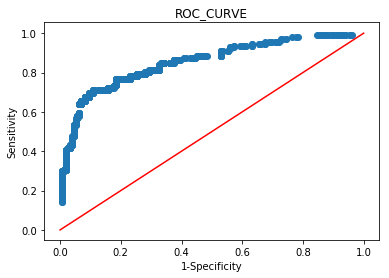

In [26]:
Sens,Spec= plot_roccurve(testx,testy.values,coeff,num_points=1000)

In [27]:
#Newton's method yields same solution in 5 iterations 
LossNewton=[]
def NewtonOptim(trainx,trainy,iters=10):
    n = trainx.shape[1]
    coeff= np.zeros((n,1))
    m=trainx.shape[0]
    trainy=trainy.reshape(m,1)
    for iterations in range(10):
        prediction= sigmoid(trainx.dot(coeff))
        loss= -np.sum(trainy*np.log(prediction)+(1-trainy)*np.log(1-prediction))/m
        vartrainy = prediction*(1-prediction).reshape(m,1)
        vartrainy = np.eye(m)*vartrainy
        hess = -(trainx.T).dot(vartrainy.dot(trainx))
        coeff = coeff-np.linalg.inv(hess).dot((trainx.T).dot(trainy-prediction))
        LossNewton.append(loss)
        print(loss)
    return coeff,LossNewton,hess

In [29]:
NewCoeff,NewtonLoss,hess=NewtonOptim(trainx,trainy.values,iters=10)  

0.6931471805599454
0.44631037910018445
0.4279026153391865
0.42688057342834207
0.4268742767717537
0.42687427615113305
0.42687427615113305
0.42687427615113305
0.42687427615113305
0.42687427615113305


In [30]:
def compute_pvalue(trainx,coeff,hess):
    m=trainx.shape[0]
    n=trainx.shape[1]
    tstatistic= coeff/np.sqrt(np.diag(np.linalg.inv(-hess))).reshape(n,1)
    df=m-n
    pvalue = [2*(1-stats.t.cdf(tstat,df)) if tstat>0 else 2*stats.t.cdf(tstat,df) for tstat in tstatistic]
    return pvalue

In [31]:
pvalue=compute_pvalue(trainx,coeff,hess)

#important features
(pd.Series(pvalue) < 0.05)[1:]

1      True
2      True
3     False
4     False
5     False
6     False
7      True
8      True
9     False
10     True
11     True
12    False
13    False
14    False
15     True
dtype: bool

In [32]:
important_features=data.columns[(pd.Series(pvalue) < 0.05)[1:]]
print(important_features)

Index(['Age', 'SibSp', 'Sex_male', 'Cabin_B', 'Cabin_D', 'Cabin_E',
       'Embarked_S'],
      dtype='object')
